<br>
<font>
<div dir=ltr align=center>
<img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" width=200 height=200>
<br>
<font color=0F5298 size=8>
Introduction to Machine Learning <br>
<font color=696880 size=5>
<!-- <br> -->
Computer Engineering Department
<br>
Sharif University of Technology

<font color=696880 size=5>
<br>
CE 40477 - Fall 2024

<font color=GREEN size=5>
<br>
Mahan Bayhaghi & Nikan Vasei
<!-- <br> -->

____

# Ensemble Learning

In [288]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

## Decision Tree Classifier

### Quick Review
- **Decision Tree** is a `supervised` machine learning model used for both classification and regression tasks.
- It models decisions based on features by splitting the dataset into smaller subsets.
- Each `node` in the tree represents a `feature`, and `edges` represent the `decision` based on a feature's value. 
- The goal is to create a model that predicts the value of a target variable by learning `decision rules` from the features.

### How it works
- A decision tree recursively splits the data into two or more homogeneous sets based on the `most significant attribute`. The splitting is guided by various metrics, like `Information Gain (IG)` or `Gini Impurity`.

### Methods of Decision Trees
1. **Information Gain (IG)**
    - Information gain measures the reduction in entropy (uncertainty) after a dataset is split on a feature.
    - Entropy is calculated as: 
    $$
    Entropy(S) = - \sum p(x)log_2p(x)
    $$
    - The higher the information gain, the better the feature is at splitting the data.

2. **Gini Impurity**
    - Measures the likelihood of an incorrect classification if a random sample is classified based on the distribution of labels.
    - Gini impurity is calculated as:
    $$
    Gini(S) = 1 - \sum p(x)^2
    $$
    - Lower Gini values indicate purer splits.

### Steps to Create a Decision Tree
1. **Select the Best Feature**: The dataset is split based on a feature that provides the best separation.
2. **Calculate Entropy or Gini**: These metrics help determine how pure the subsets are.
3. **Recursively Split**: The tree splits the dataset recursively until a stopping condition is met (like max depth or min samples).
4. **Assign Labels**: Once the tree reaches the leaf nodes, it assigns a predicted class label.


*Below we're going to use the IG method to implement the Decision Tree class from scratch.*

In [289]:
class Node:
    """
    A class representing a node in a decision tree.
    """

    def __init__(self, feature=None, threshold=None, left=None, right=None, gain=None, value=None):
        """
        Initializes a new instance of the Node class.

        Parameters:
        ----------
        feature : int, optional
            The index of the feature used for splitting at this node.
        threshold : float, optional
            The threshold value for splitting the dataset at this node.
        left : Node, optional
            The left child node resulting from the split.
        right : Node, optional
            The right child node resulting from the split.
        gain : float, optional
            The information gain of the split at this node.
        value : int or float, optional
            If this node is a leaf node, this represents the predicted value.
        """
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.gain = gain
        self.value = value

In [290]:
class DecisionTree():
    """
    A decision tree classifier for binary classification problems.
    """

    def __init__(self, min_samples=2, max_depth=2):
        """
        Constructor for DecisionTree class.

        Parameters:
        ----------
        min_samples : int
            Minimum number of samples required to split an internal node.
        max_depth : int
            Maximum depth of the decision tree.
        """
        self.min_samples = min_samples
        self.max_depth = max_depth

    def _split_data(self, dataset, feature, threshold):
        """
        Splits the given dataset into two datasets based on the given feature and threshold.

        Parameters:
        ----------
        dataset : ndarray
            Input dataset.
        feature : int
            Index of the feature to be split on.
        threshold : float
            Threshold value to split the feature on.

        Returns:
        -------
        left_dataset : ndarray
            Subset of the dataset with values less than or equal to the threshold.
        right_dataset : ndarray
            Subset of the dataset with values greater than the threshold.
        """
        # Create empty arrays to store the left and right datasets
        left_dataset = []
        right_dataset = []
        
        # Loop over each row in the dataset and split based on the given feature and threshold
        for row in dataset:
            if row[feature] <= threshold:
                left_dataset.append(row)
            else:
                right_dataset.append(row)

        # Convert the left and right datasets to numpy arrays and return
        left_dataset = np.array(left_dataset)
        right_dataset = np.array(right_dataset)
        return left_dataset, right_dataset

    def _entropy(self, y):
        """
        Computes the entropy of the given label values.

        Parameters:
        ----------
        y : ndarray
            Input label values.

        Returns:
        -------
        entropy : float
            Entropy of the given label values.
        """
        entropy = 0

        # Find the unique label values in y and loop over each value
        labels = np.unique(y)
        for label in labels:
            # Find the examples in y that have the current label
            label_examples = y[y == label]
            # Calculate the ratio of the current label in y
            pl = len(label_examples) / len(y)
            # Calculate the entropy using the current label and ratio
            entropy += -pl * np.log2(pl)

        # Return the final entropy value
        return entropy

    def _information_gain(self, parent, left, right):
        """
        Computes the information gain from splitting the parent dataset into two datasets.

        Parameters:
        ----------
        parent : ndarray
            Input parent dataset.
        left : ndarray
            Subset of the parent dataset after split on a feature.
        right : ndarray
            Subset of the parent dataset after split on a feature.

        Returns:
        -------
        information_gain : float
            Information gain of the split.
        """
        # Set initial information gain to 0
        information_gain = 0
        # Compute entropy for parent
        parent_entropy = self._entropy(parent)
        # Calculate weight for left and right nodes
        weight_left = len(left) / len(parent)
        weight_right= len(right) / len(parent)
        # Compute entropy for left and right nodes
        entropy_left, entropy_right = self._entropy(left), self._entropy(right)
        # Calculate weighted entropy 
        weighted_entropy = weight_left * entropy_left + weight_right * entropy_right
        # Calculate information gain 
        information_gain = parent_entropy - weighted_entropy
        return information_gain
    
    def _best_split(self, dataset, num_features):
        """
        Finds the best split for the given dataset.

        Parameters:
        ----------
        dataset : ndarray
            The dataset to split.
        num_samples : int
            The number of samples in the dataset.
        num_features : int
            The number of features in the dataset.

        Returns:
        -------
        best_split : dict
            A dictionary with the best split feature index, threshold, gain, left, and right datasets.
        """
        # Dictionary to store the best split values
        best_split = {'gain': -1}
        # Loop over all the features
        for feature_index in range(num_features):
            # Get the feature at the current feature_index
            feature_values = dataset[:, feature_index]
            # Get unique values of that feature
            thresholds = np.unique(feature_values)
            # Loop over all values of the feature
            for threshold in thresholds:
                # Get left and right datasets
                left_dataset, right_dataset = self._split_data(dataset, feature_index, threshold)
                # Check if either datasets is empty
                if len(left_dataset) and len(right_dataset):
                    # Get y values of the parent and left, right nodes
                    y, left_y, right_y = dataset[:, -1], left_dataset[:, -1], right_dataset[:, -1]
                    # Compute information gain based on the y values
                    information_gain = self._information_gain(y, left_y, right_y)
                    # Update the best split if conditions are met
                    if information_gain > best_split["gain"]:
                        best_split["feature"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["left_dataset"] = left_dataset
                        best_split["right_dataset"] = right_dataset
                        best_split["gain"] = information_gain
        return best_split
    
    def _calculate_leaf_value(self, y):
        """
        Calculates the most occurring value in the given list of y values.

        Parameters:
        ----------
        y : list
            The list of y values.

        Returns:
        -------
        most_occurring_value : int or float
            The most occurring value in the list.
        """
        y = list(y)
        # Get the highest present class in the array
        most_occurring_value = max(y, key=y.count)
        return most_occurring_value
    
    def _build_tree(self, dataset, current_depth=0):
        """
        Recursively builds a decision tree from the given dataset.

        Parameters:
        ----------
        dataset : ndarray
            The dataset to build the tree from.
        current_depth : int
            The current depth of the tree.

        Returns:
        -------
        Node : Node
            The root node of the built decision tree.
        """
        # Split the dataset into X, y values
        X, y = dataset[:, :-1], dataset[:, -1]
        n_samples, n_features = X.shape
        # Keeps splitting until stopping conditions are met
        if n_samples >= self.min_samples and current_depth <= self.max_depth:
            # Get the best split
            best_split = self._best_split(dataset, n_features)
            # Check if the gain isn't zero
            if best_split["gain"]:
                # Continue splitting the left and the right child. Increment current depth
                left_node = self._build_tree(best_split["left_dataset"], current_depth + 1)
                right_node = self._build_tree(best_split["right_dataset"], current_depth + 1)
                # Return decision node
                return Node(best_split["feature"], best_split["threshold"], left_node, right_node, best_split["gain"])

        # Compute the leaf node value
        leaf_value = self._calculate_leaf_value(y)
        # Return the leaf node value
        return Node(value=leaf_value)
    
    def fit(self, X, y):
        """
        Builds and fits the decision tree to the given X and y values.

        Parameters:
        ----------
        X : ndarray
            The feature matrix.
        y : ndarray
            The target values.
        """
        dataset = np.concatenate((X, y), axis=1)  
        self.root = self._build_tree(dataset)

    def predict(self, X):
        """
        Predicts the class labels for each instance in the feature matrix X.

        Parameters:
        ----------
        X : ndarray
            The feature matrix to make predictions for.

        Returns:
        -------
        predictions : list
            A list of predicted class labels.
        """
        # Create an empty list to store the predictions
        predictions = []
        # For each instance in X, make a prediction by traversing the tree
        for x in X:
            prediction = self._make_prediction(x, self.root)
            # Append the prediction to the list of predictions
            predictions.append(prediction)
        # Convert the list to a numpy array and return it
        np.array(predictions)
        return predictions
    
    def _make_prediction(self, x, node):
        """
        Traverses the decision tree to predict the target value for the given feature vector.

        Parameters:
        ----------
        x : ndarray
            The feature vector to predict the target value for.
        node : Node
            The current node being evaluated.

        Returns:
        -------
        prediction : int or float
            The predicted target value for the given feature vector.
        """
        # If the node has value i.e it's a leaf node extract it's value
        if node.value != None: 
            return node.value
        else:
            # If it's node a leaf node we'll get it's feature and traverse through the tree accordingly
            feature = x[node.feature]
            if feature <= node.threshold:
                return self._make_prediction(x, node.left)
            else:
                return self._make_prediction(x, node.right)

In this section, we'll use the `Iris plants` dataset which is a binary classification dataset.

**Dataset Characteristics**:
- Number of Instances: 150 (50 in each of three classes)
- Number of Attributes: 4 numeric, predictive attributes and the class

**Attribute Information**:
- sepal length in cm
- sepal width in cm
- petal length in cm
- petal width in cm
- **class**:
    - Iris-Setosa
    - Iris-Versicolour
    - Iris-Virginica

We use the Iris dataset because it's simple, well-balanced, and requires minimal preprocessing. This allows us to focus on building and evaluating the decision tree model without the need for complex data preparation.

In [291]:
from sklearn.datasets import load_iris

iris = load_iris()

X, y = iris.data, iris.target

print(f"Iris features: {iris.feature_names}")
print(f"Iris target: {iris.target_names}")

Iris features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Iris target: ['setosa' 'versicolor' 'virginica']


Now we can split the dataset into train and test sets. 

Also ensure that `y` is reshaped to avoid dimensional errors during model training.

In [292]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y.reshape(-1,1), test_size=0.2, random_state=42)

print(f"Shape of X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}, y_test: {y_test.shape}")

Shape of X_train: (120, 4), y_train: (120, 1)
Shape of X_test: (30, 4), y_test: (30, 1)


Now we can train our custom `DecisionTree()` model and evaluate its performance using both the `accuracy_score` and the `f1_score`.

In [293]:
from sklearn.metrics import accuracy_score, f1_score

# Create a DT model.
dt_custom = DecisionTree(2, 2)

# Fit the DT model to the training data.
dt_custom.fit(X_train, y_train)

# Make predictions using the DT model.
dt_cust_predictions = dt_custom.predict(X_test)

# Calculate evaluating metrics for the DT model.
print(f"Custom DT Accuracy: {accuracy_score(y_test, dt_cust_predictions):.3f}")
print(f"Custom DT F1-Score: {f1_score(y_test, dt_cust_predictions, average='weighted'):.3f}")

Custom DT Accuracy: 0.967
Custom DT F1-Score: 0.966


### Using Scikit-learn's Decision Tree Classifier
After implementing a custom Decision Tree from scratch, we will now compare the results by utilizing the Scikit-learn library, which provides a highly optimized implementation of decision trees. This allows us to observe the behavior of decision trees without dealing with the complexities of manually building one. We’ll also visualize the decision tree to gain insight into how it makes decisions.

Sklearn DT Accuracy: 0.967
Sklearn DT F1-Score: 0.966


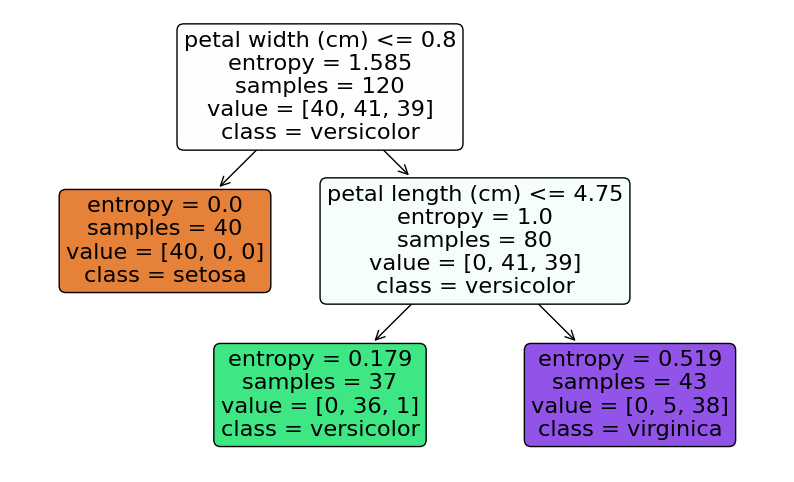

In [294]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Initialize a DecisionTreeClassifier from sklearn.
dt_sklearn = DecisionTreeClassifier(criterion='entropy', max_depth=2)

# Fit the sklearn DT model to the training data.
dt_sklearn.fit(X_train, y_train)

# Make predictions using the sklearn DT model.
dt_skl_predictions = dt_sklearn.predict(X_test)

# Calculate evaluating metrics for the sklearn DT model.
print(f"Sklearn DT Accuracy: {accuracy_score(y_test, dt_skl_predictions):.3f}")
print(f"Sklearn DT F1-Score: {f1_score(y_test, dt_skl_predictions, average='weighted'):.3f}")

# Plot the decision tree.
plt.figure(figsize=(10,6))
plt.title("Decision Tree Visualization - Sklearn")
plot_tree(dt_sklearn, feature_names=list(iris.feature_names), class_names=list(iris.target_names), filled=True, rounded=True)
plt.show()

In the plot above, you can see the decision rules that have been made for splitting the dataset.

## Random Forest

### Quick Review
- A **Random Forest** is an ensemble method that `combines multiple decision trees` to improve accuracy and reduce overfitting. 
- Each tree is trained on `random subsets` of the data and features, and their predictions are `averaged` for better performance.
- It’s robust, reduces variance, and works well for both classification and regression.

### Steps to Create a Random Forest
1. **Bagging**: Randomly sample subsets of the data (with replacement) for each tree.
2. For each tree, randomly select a subset of features at each split.
3. Train a decision tree on each sampled dataset.
4. Repeat steps 1–3 to build multiple decision trees.
5. **Aggregating**: For predictions, aggregate the outputs of all the trees (e.g., majority vote for classification or averaging for regression).

In [295]:
class RandomForest:
    """
    A random forest classifier.

    Parameters
    ----------
    n_trees : int, default=10
        The number of trees in the random forest.
    max_depth : int, default=2
        The maximum depth of each decision tree in the random forest.
    min_samples : int, default=7
        The minimum number of samples required to split an internal node
        of each decision tree in the random forest.

    Attributes
    ----------
    n_trees : int
        The number of trees in the random forest.
    max_depth : int
        The maximum depth of each decision tree in the random forest.
    min_samples : int
        The minimum number of samples required to split an internal node
        of each decision tree in the random forest.
    trees : list of DecisionTree
        The decision trees in the random forest.
    """

    def __init__(self, n_trees=7, min_samples=7, max_depth=2):
        """
        Initialize the random forest classifier.

        Parameters
        ----------
        n_trees : int, default=10
            The number of trees in the random forest.
        max_depth : int, default=2
            The maximum depth of each decision tree in the random forest.
        min_samples : int, default=7
            The minimum number of samples required to split an internal node
            of each decision tree in the random forest.
        """
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples = min_samples
        self.trees = []

    def fit(self, X, y):
        """
        Build a random forest classifier from the training set (X, y).

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            The training input samples.
        y : array-like of shape (n_samples,)
            The target values.

        Returns
        -------
        self : object
            Returns self.
        """
        # Create an empty list to store the trees.
        self.trees = []
        # Concatenate X and y into a single dataset.
        dataset = np.concatenate((X, y), axis=1)
        # Loop over the number of trees.
        for _ in range(self.n_trees):
            # Create a decision tree instance.
            tree = DecisionTree(min_samples=self.min_samples, max_depth=self.max_depth)
            # Sample from the dataset with replacement (bootstrapping).
            dataset_sample = self._bootstrap_samples(dataset)
            # Get the X and y samples from the dataset sample.
            X_sample, y_sample = dataset_sample[:, :-1], dataset_sample[:, -1].reshape(-1, 1)
            # Fit the tree to the X and y samples.
            tree.fit(X_sample, y_sample)
            # Store the tree in the list of trees.
            self.trees.append(tree)

    def _bootstrap_samples(self, dataset):
        """
        Bootstrap the dataset by sampling from it with replacement.

        Parameters
        ----------
        dataset : array-like of shape (n_samples, n_features + 1)
            The dataset to bootstrap.

        Returns
        -------
        dataset_sample : array-like of shape (n_samples, n_features + 1)
            The bootstrapped dataset sample.
        """
        # Get the number of samples in the dataset.
        n_samples = dataset.shape[0]
        # Generate random indices to index into the dataset with replacement.
        np.random.seed(42)
        indices = np.random.choice(n_samples, n_samples, replace=True)
        # Return the bootstrapped dataset sample using the generated indices.
        dataset_sample = dataset[indices]
        return dataset_sample

    def _most_common_label(self, y):
        """
        Return the most common label in an array of labels.

        Parameters
        ----------
        y : array-like of shape (n_samples,)
            The array of labels.

        Returns
        -------
        most_occurring_value : int or float
            The most common label in the array.
        """
        y = list(y)
        # Get the highest present class in the array
        most_occurring_value = max(y, key=y.count)
        return most_occurring_value

    def predict(self, X):
        """
        Predict class for X.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            The input samples.

        Returns
        -------
        majority_predictions : array-like of shape (n_samples,)
            The predicted classes.
        """
        # Get prediction from each tree in the tree list on the test data
        predictions = np.array([tree.predict(X) for tree in self.trees])
        # Get prediction for the same sample from all trees for each sample in the test data
        preds = np.swapaxes(predictions, 0, 1)
        # Get the most voted value by the trees and store it in the final predictions array
        majority_predictions = np.array([self._most_common_label(pred) for pred in preds])
        return majority_predictions

In this section, we'll use the `Breast cancer wisconsin (diagnostic)` dataset which is a binary classification dataset.

**Dataset Characteristics**:
- Number of Instances: 569
- Number of Attributes: 30 numeric, predictive attributes and the class

**Attribute Information**:
- radius (mean of distances from center to points on the perimeter)
- texture (standard deviation of gray-scale values)
- perimeter
- area
- smoothness (local variation in radius lengths)
- compactness (perimeter^2 / area - 1.0)
- concavity (severity of concave portions of the contour)
- concave points (number of concave portions of the contour)
- symmetry
- fractal dimension (“coastline approximation” - 1)
- **class**:
    - WDBC-Malignant
    - WDBC-Benign

*The mean, standard error, and “worst” or largest (mean of the three worst/largest values) of these features were computed for each image, resulting in 30 features. For instance, field 0 is Mean Radius, field 10 is Radius SE, field 20 is Worst Radius.*

In [296]:
from sklearn.datasets import load_breast_cancer

breast_cancer = load_breast_cancer()

X, y = breast_cancer.data, breast_cancer.target

print(f"Breast Cancer features: {breast_cancer.feature_names}")
print(f"Breast Cancer target: {breast_cancer.target_names}")

Breast Cancer features: ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']
Breast Cancer target: ['malignant' 'benign']


Now we can split the dataset into train and test sets. 

Also ensure that `y` is reshaped to avoid dimensional errors during model training.

In [297]:
X_train, X_test, y_train, y_test = train_test_split(X, y.reshape(-1,1), test_size=0.2, random_state=42)

print(f"Shape of X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}, y_test: {y_test.shape}")

Shape of X_train: (455, 30), y_train: (455, 1)
Shape of X_test: (114, 30), y_test: (114, 1)


Now we can train our custom `RandomForest()` model and evaluate its performance using both the `accuracy_score` and the `f1_score`.

In [298]:
# Create an RF model
rf_custom = RandomForest()

# Fit the RF model to the training data
rf_custom.fit(X_train, y_train)

# Use the trained RF model to make predictions on the test data
rf_cust_predictions = rf_custom.predict(X_test)

# Calculate evaluating metrics for the RF model
print(f"Custom RF Accuracy: {accuracy_score(y_test, rf_cust_predictions):.3f}")
print(f"Custom RF F1-Score: {f1_score(y_test, rf_cust_predictions, average='weighted'):.3f}")

Custom RF Accuracy: 0.939
Custom RF F1-Score: 0.938


### Using Scikit-learn's Random Forest Classifier
After implementing a custom Random Forest from scratch, we will now compare the results by utilizing the Scikit-learn library, which provides a highly optimized implementation of random forests. This allows us to observe the behavior of random forests without dealing with the complexities of manually building one. We’ll also visualize the decision trees used in the random forest to gain insight into how it makes decisions.

In [299]:
from sklearn.ensemble import RandomForestClassifier

# Initialize a RandomForestClassifier from sklearn.
rf_sklearn = RandomForestClassifier(n_estimators=7, min_samples_split=7, max_depth=2, criterion='entropy', random_state=6)

# Fit the sklearn RF model to the training data.
rf_sklearn.fit(X_train, y_train.ravel())

# Make predictions using the sklearn DT model.
rf_skl_predictions = rf_sklearn.predict(X_test)

# Calculate evaluating metrics for the sklearn DT model.
print(f"Sklearn RF Accuracy: {accuracy_score(y_test, rf_skl_predictions):.3f}")
print(f"Sklearn RF F1-Score: {f1_score(y_test, rf_skl_predictions, average='weighted'):.3f}")

Sklearn RF Accuracy: 0.939
Sklearn RF F1-Score: 0.938


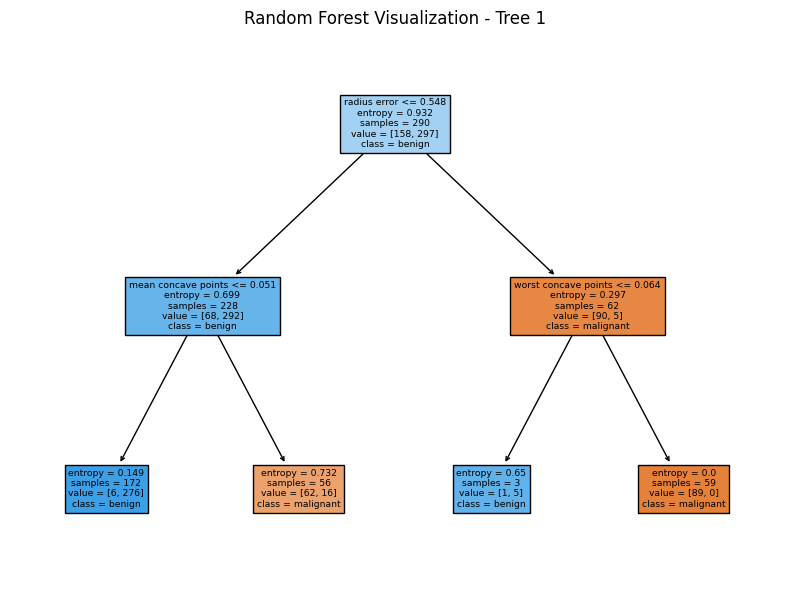

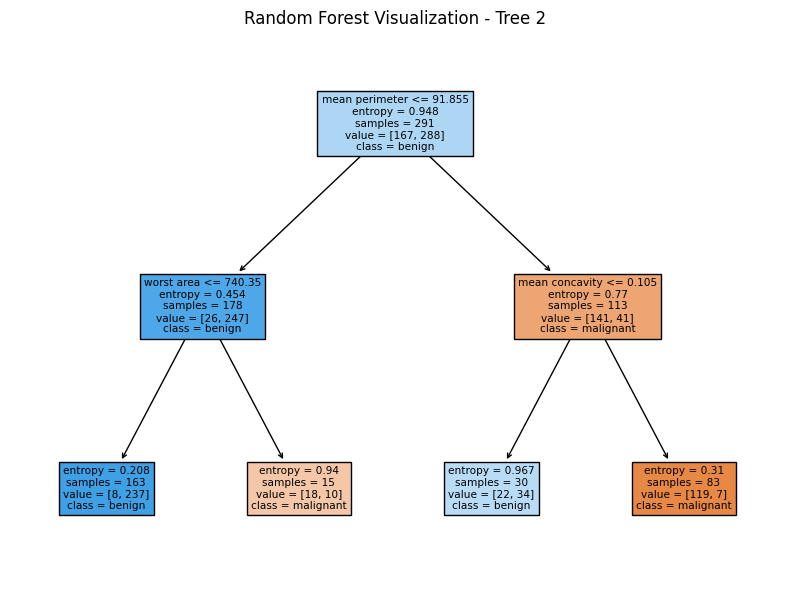

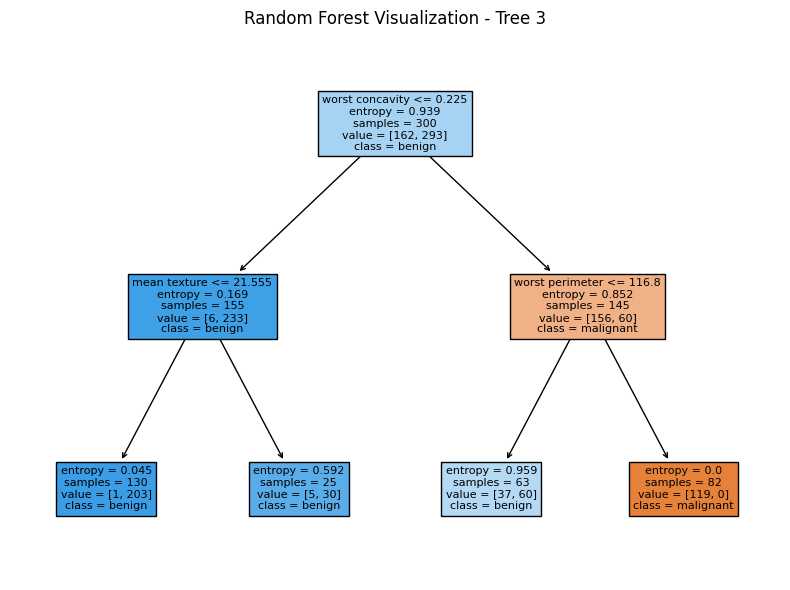

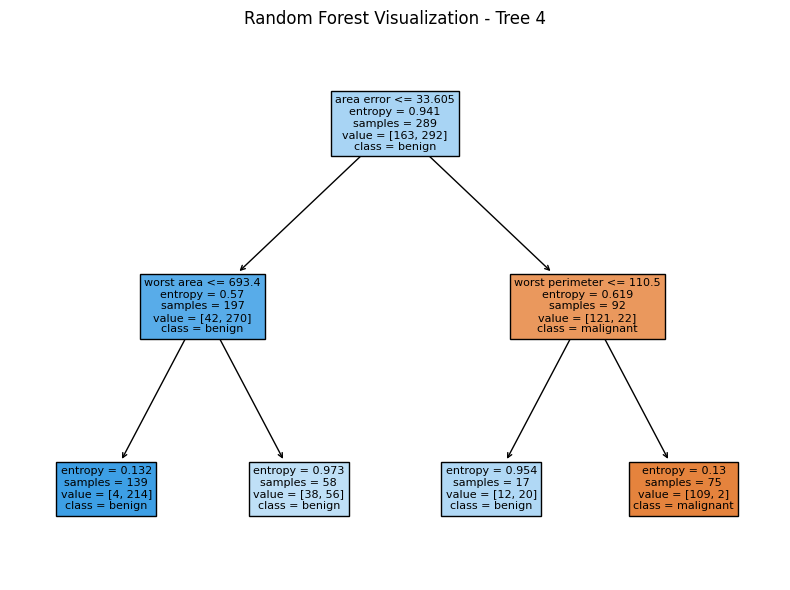

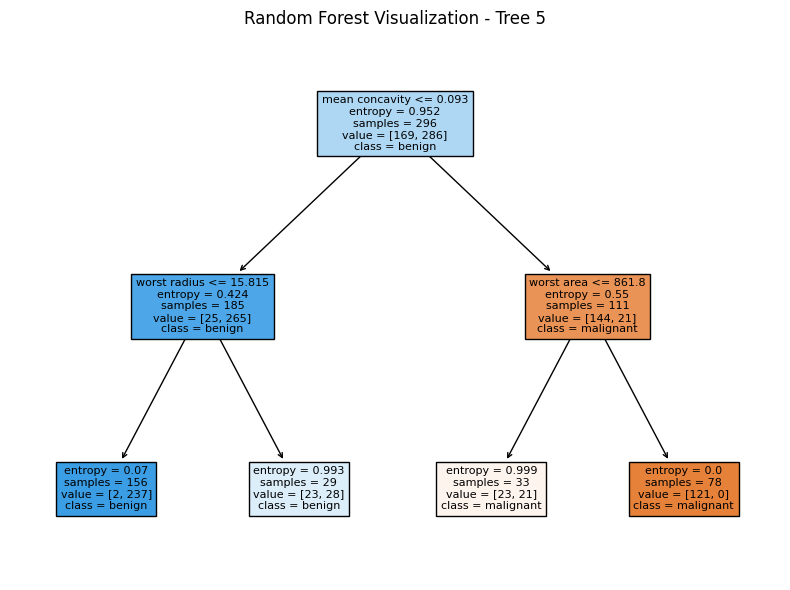

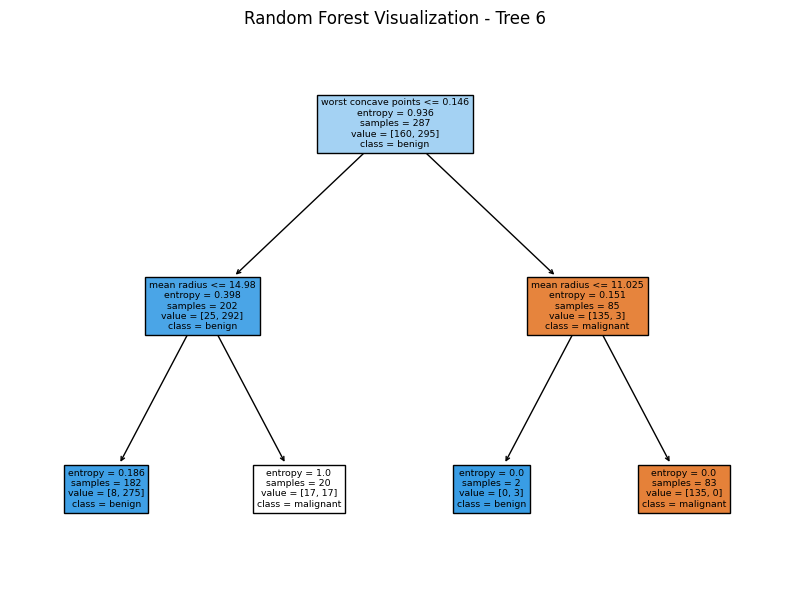

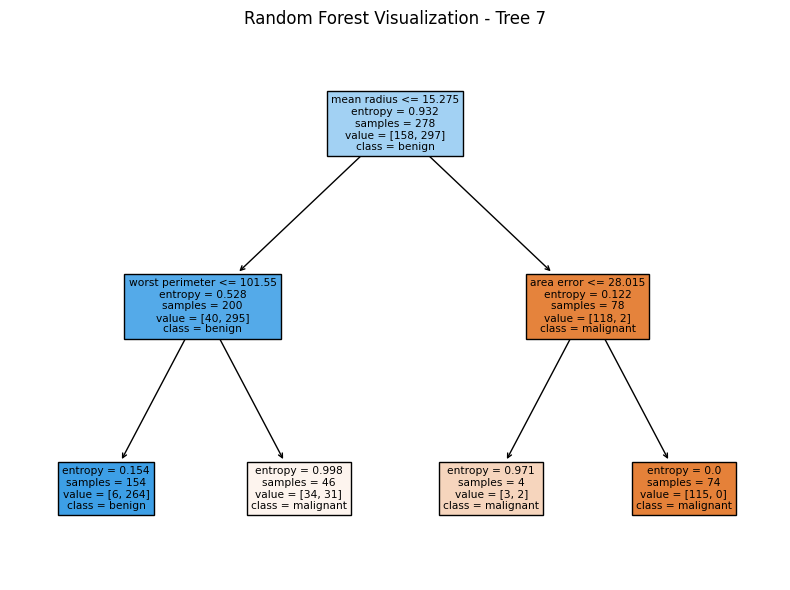

In [300]:
for idx, tree in enumerate(rf_sklearn.estimators_):
    plt.figure(figsize=(8,6))
    plot_tree(tree, filled=True, feature_names=list(breast_cancer.feature_names), class_names=list(breast_cancer.target_names))
    plt.title(f"Random Forest Visualization - Tree {idx + 1}")
    plt.tight_layout()
    plt.show()

In [301]:
# Choose a random sample for illustration
sample_idx = 112

# Print its values
pd.set_option('display.max_columns', None)
pd.DataFrame(X_test[112].reshape(1, -1), columns=breast_cancer.feature_names).head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,14.22,27.85,92.55,623.9,0.08223,0.1039,0.1103,0.04408,0.1342,0.06129,0.3354,2.324,2.105,29.96,0.006307,0.02845,0.0385,0.01011,0.01185,0.003589,15.75,40.54,102.5,764.0,0.1081,0.2426,0.3064,0.08219,0.189,0.07796


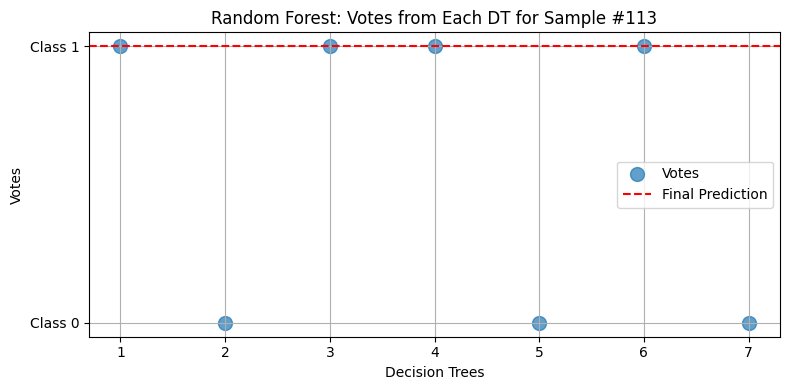

In [302]:
# Get predictions (votes) from each tree in the Random Forest
votes = [tree.predict(X_test[112].reshape(1, -1)) for tree in rf_sklearn.estimators_]
# Final prediction
final_prediction = rf_sklearn.predict(X_test[sample_idx].reshape(1, -1))[0]

plt.figure(figsize=(8, 4))
# Create a scatter plot to show individual trees' votes
plt.scatter([range(1, len(rf_sklearn.estimators_) + 1)], votes, s=100, alpha=0.7, label='Votes')
# Draw a horizontal line to indicate the final prediction
plt.axhline(y=final_prediction, color='r', linestyle='--', label='Final Prediction')
plt.yticks([0, 1], ['Class 0', 'Class 1'])

plt.xlabel('Decision Trees')
plt.ylabel('Votes')
plt.title(f'Random Forest: Votes from Each DT for Sample #{sample_idx + 1}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## XGBoost

You've learned about the `AdaBoost` algorithm in class and through the slides. Another prominent algorithm within the ensemble methods is `XGBoost`. While you may have encountered it before, you can explore more details through this [link]((https://en.wikipedia.org/wiki/XGBoost)). This algorithm builds upon the decision trees you studied earlier.

**XGBoost**, or Extreme Gradient Boosting, is an efficient and scalable implementation of the gradient boosting framework. It is widely used in machine learning competitions and practical applications due to its speed and performance. XGBoost enhances the standard gradient boosting algorithm by introducing optimizations and regularization techniques, making it robust against overfitting.

### Key Features of XGBoost:
- Parallel Processing: Utilizes parallel and distributed computing to speed up training.
- Regularization: Incorporates `L1 (Lasso)` and `L2 (Ridge)` regularization to control overfitting.
- Tree Pruning: Employs a depth-first approach to prune trees, leading to faster computations.
- Handling Missing Values: Automatically learns how to handle missing data, eliminating the need for imputation.
- Feature Importance: Provides insights into feature importance for better interpretability.


### How it works
1. **Initialization**: Starts with an initial prediction (e.g., mean value).
2. **Building Trees**: Iteratively adds decision trees to minimize the loss function.
3. **Gradient Descent**: Uses the gradients of the loss function to fit new trees, improving the model iteratively.
4. **Boosting Process**: Combines the predictions of all trees to form a strong learner, reducing bias and variance.

Below is an overview of how XGBoost works:

<dev style="text-align: center">
<img src="./assets/XGBoost.png" />
</dev>

In this section, again we'll use the `Breast cancer wisconsin (diagnostic)` dataset which is a binary classification dataset.

In [303]:
from xgboost import XGBClassifier, to_graphviz

# Initialize a XGBoostClassifier.
xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)

# Fit the XGB model to the training data.
xgb_model.fit(X_train, y_train.ravel())

# Make predictions using the XGB model.
xgb_predictions = xgb_model.predict(X_test)

# Calculate evaluating metrics for the sklearn DT model.
print(f"XGB Accuracy: {accuracy_score(y_test, xgb_predictions):.3f}")
print(f"XGB F1-Score: {f1_score(y_test, xgb_predictions, average='weighted'):.3f}")

XGB Accuracy: 0.956
XGB F1-Score: 0.956


We can also use the built-in functions to plot the XGB decision rules.

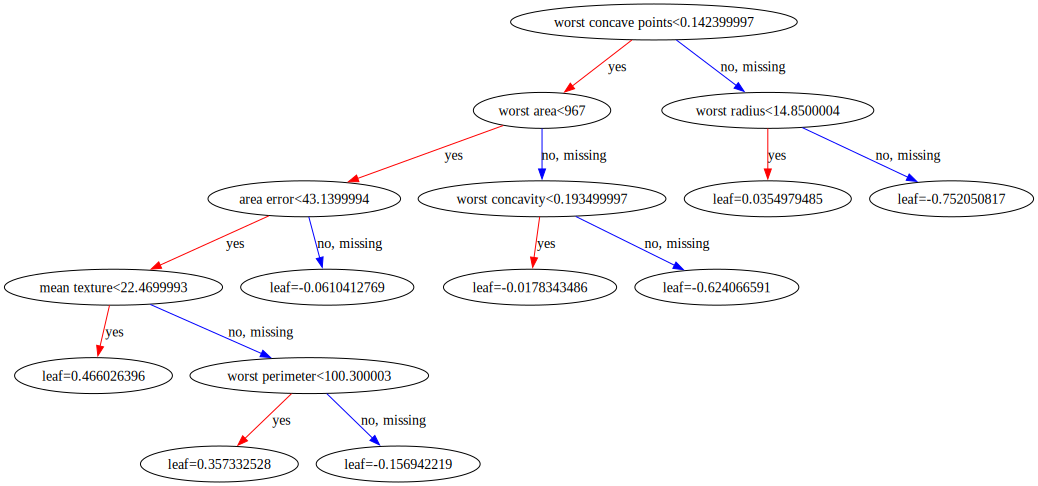

In [304]:
xgb_model.get_booster().feature_names = list(breast_cancer.feature_names)
graph = to_graphviz(xgb_model)
graph

## Comparisons

First, we will utilize the `Breast Cancer Wisconsin (Diagnostic)` dataset to compare the accuracy of the two primary methods discussed earlier: `Random Forest` and `XGBoost`.

Random Forest Accuracy: 0.9561
XGBoost Accuracy: 0.9561


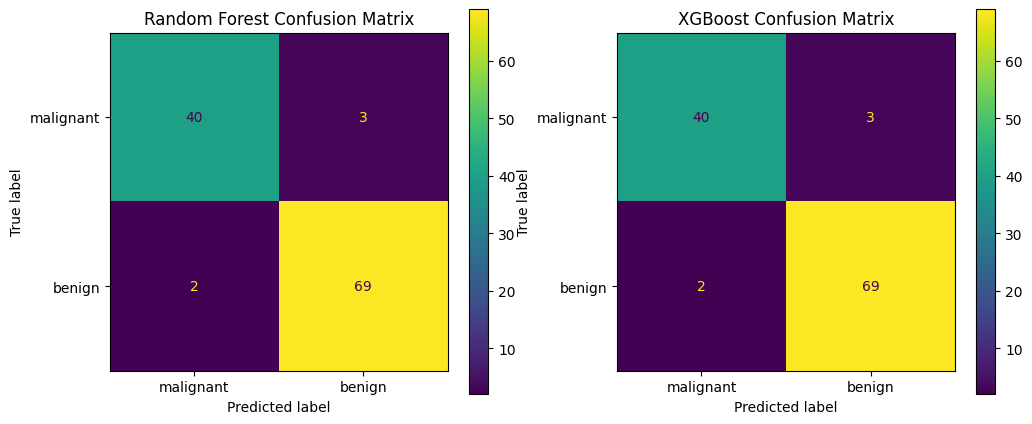


Random Forest Classification Report:
               precision    recall  f1-score   support

   malignant       0.95      0.93      0.94        43
      benign       0.96      0.97      0.97        71

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114

------------------------------------------------------------

XGBoost Classification Report:
               precision    recall  f1-score   support

   malignant       0.95      0.93      0.94        43
      benign       0.96      0.97      0.97        71

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



In [305]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=10, random_state=42)
rf_model.fit(X_train, y_train.ravel())
rf_predictions = rf_model.predict(X_test)

# Train XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)

# Compare Their Accuracies
rf_accuracy = accuracy_score(y_test, rf_predictions)
xgb_accuracy = accuracy_score(y_test, xgb_predictions)

print(f"Random Forest Accuracy: {rf_accuracy:.4f}")
print(f"XGBoost Accuracy: {xgb_accuracy:.4f}")

# Confusion Matrices
_, ax = plt.subplots(1, 2, figsize=(12, 5))

# Random Forest Confusion Matrix
cm_rf = confusion_matrix(y_test, rf_predictions)
ConfusionMatrixDisplay(cm_rf, display_labels=list(breast_cancer.target_names)).plot(ax=ax[0])
ax[0].set_title('Random Forest Confusion Matrix')

# XGBoost Confusion Matrix
cm_xgb = confusion_matrix(y_test, xgb_predictions)
ConfusionMatrixDisplay(cm_xgb, display_labels=list(breast_cancer.target_names)).plot(ax=ax[1])
ax[1].set_title('XGBoost Confusion Matrix')

plt.show()

# Classification Reports
print("\nRandom Forest Classification Report:\n", classification_report(y_test, rf_predictions, target_names=list(breast_cancer.target_names)))
print("-" * 60)
print("\nXGBoost Classification Report:\n", classification_report(y_test, xgb_predictions, target_names=list(breast_cancer.target_names)))

We can see that they have a quite similar performance in simple and `balanced` datasets like the one above.

But there are many proofs that XGBoost works much better than the Random Forest, when we're working with `imbalanced` datasets. Below we can compare them again on a different (imbalanced) dataset.

For this task, we'll use three different imbalanced datasets which are located in the "./assets/imbalanced_datasets" directory.

In [306]:
pd1 = pd.read_csv("./assets/imbalanced_datasets/1.csv")
pd2 = pd.read_csv("./assets/imbalanced_datasets/2.csv")
pd3 = pd.read_csv("./assets/imbalanced_datasets/3.csv")

print(f"Shape of the first dataset: {pd1.shape}")
print(f"Shape of the second dataset: {pd2.shape}")
print(f"Shape of the third dataset: {pd3.shape}")

Shape of the first dataset: (725, 14)
Shape of the second dataset: (625, 14)
Shape of the third dataset: (525, 14)


In [307]:
X1, y1 = pd1.drop(columns=['target']), pd1['target']
X2, y2 = pd2.drop(columns=['target']), pd2['target']
X3, y3 = pd3.drop(columns=['target']), pd3['target']

In [308]:
def test_dataset(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train Random Forest
    rf_model = RandomForestClassifier(n_estimators=10, random_state=42)
    rf_model.fit(X_train, y_train)
    rf_predictions = rf_model.predict(X_test)

    # Train XGBoost
    xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    xgb_model.fit(X_train, y_train)
    xgb_predictions = xgb_model.predict(X_test)

    # Compare Their Accuracies
    rf_accuracy = accuracy_score(y_test, rf_predictions)
    xgb_accuracy = accuracy_score(y_test, xgb_predictions)

    print(f"Random Forest Accuracy: {rf_accuracy:.4f}")
    print(f"XGBoost Accuracy: {xgb_accuracy:.4f}")

    # Confusion Matrices
    _, ax = plt.subplots(1, 2, figsize=(12, 5))

    # Random Forest Confusion Matrix
    cm_rf = confusion_matrix(y_test, rf_predictions)
    ConfusionMatrixDisplay(cm_rf, display_labels=list(breast_cancer.target_names)).plot(ax=ax[0])
    ax[0].set_title('Random Forest Confusion Matrix')

    # XGBoost Confusion Matrix
    cm_xgb = confusion_matrix(y_test, xgb_predictions)
    ConfusionMatrixDisplay(cm_xgb, display_labels=list(breast_cancer.target_names)).plot(ax=ax[1])
    ax[1].set_title('XGBoost Confusion Matrix')

    plt.show()

    # Classification Reports
    print("\nRandom Forest Classification Report:\n", classification_report(y_test, rf_predictions, target_names=list(breast_cancer.target_names)))
    print("-" * 60)
    print("\nXGBoost Classification Report:\n", classification_report(y_test, xgb_predictions, target_names=list(breast_cancer.target_names)))

Test the first dataset:

Random Forest Accuracy: 0.9793
XGBoost Accuracy: 0.9862


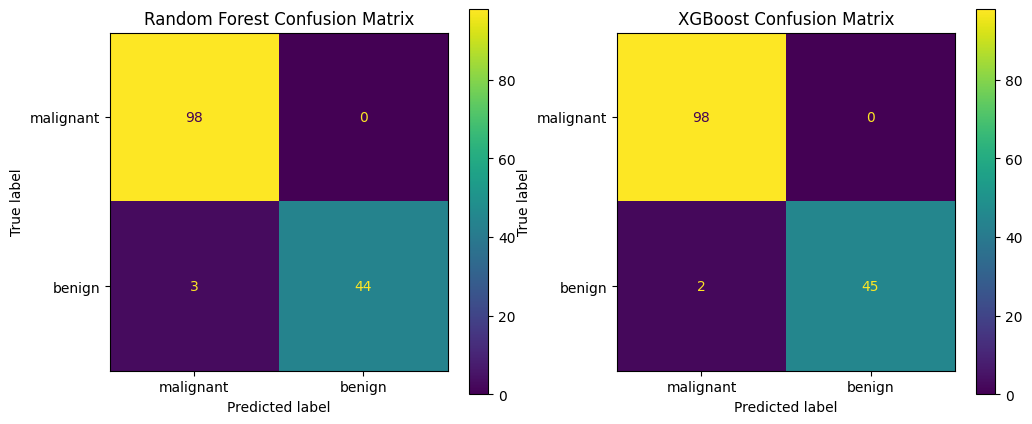


Random Forest Classification Report:
               precision    recall  f1-score   support

   malignant       0.97      1.00      0.98        98
      benign       1.00      0.94      0.97        47

    accuracy                           0.98       145
   macro avg       0.99      0.97      0.98       145
weighted avg       0.98      0.98      0.98       145

------------------------------------------------------------

XGBoost Classification Report:
               precision    recall  f1-score   support

   malignant       0.98      1.00      0.99        98
      benign       1.00      0.96      0.98        47

    accuracy                           0.99       145
   macro avg       0.99      0.98      0.98       145
weighted avg       0.99      0.99      0.99       145



In [309]:
test_dataset(X1, y1)

Random Forest Accuracy: 0.9360
XGBoost Accuracy: 0.9440


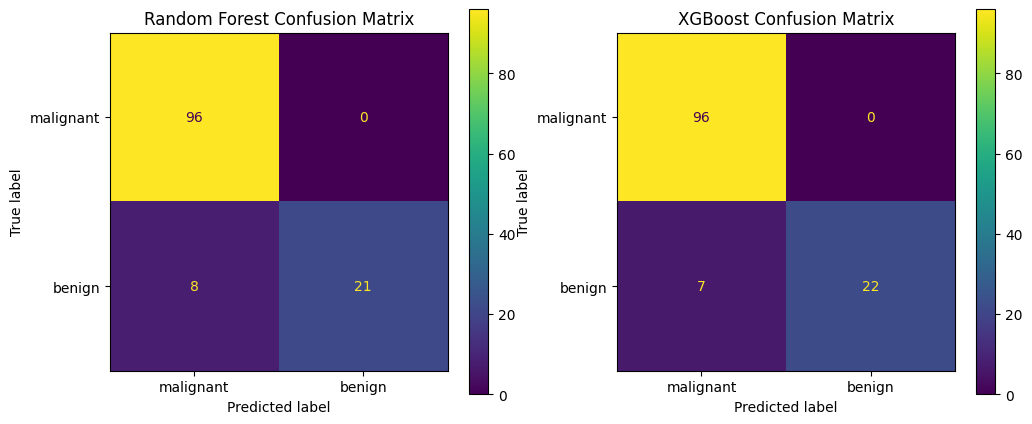


Random Forest Classification Report:
               precision    recall  f1-score   support

   malignant       0.92      1.00      0.96        96
      benign       1.00      0.72      0.84        29

    accuracy                           0.94       125
   macro avg       0.96      0.86      0.90       125
weighted avg       0.94      0.94      0.93       125

------------------------------------------------------------

XGBoost Classification Report:
               precision    recall  f1-score   support

   malignant       0.93      1.00      0.96        96
      benign       1.00      0.76      0.86        29

    accuracy                           0.94       125
   macro avg       0.97      0.88      0.91       125
weighted avg       0.95      0.94      0.94       125



In [310]:
test_dataset(X2, y2)

Random Forest Accuracy: 0.9905
XGBoost Accuracy: 0.9905


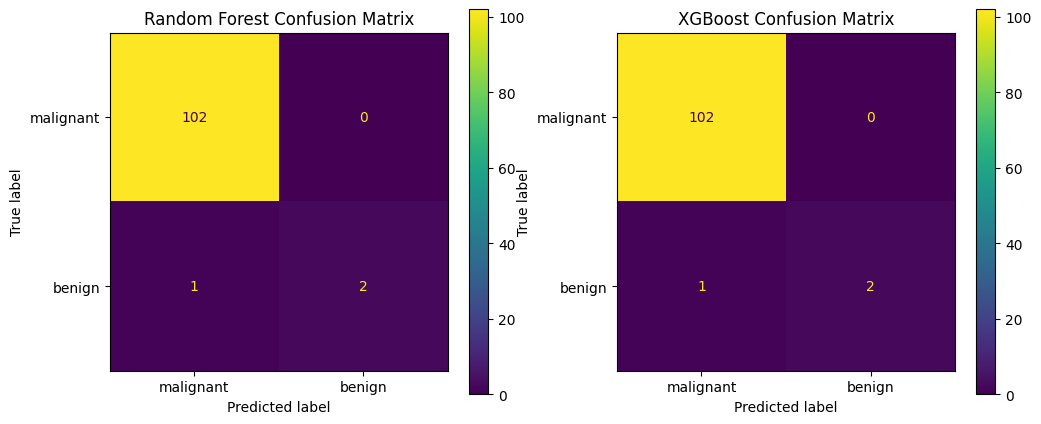


Random Forest Classification Report:
               precision    recall  f1-score   support

   malignant       0.99      1.00      1.00       102
      benign       1.00      0.67      0.80         3

    accuracy                           0.99       105
   macro avg       1.00      0.83      0.90       105
weighted avg       0.99      0.99      0.99       105

------------------------------------------------------------

XGBoost Classification Report:
               precision    recall  f1-score   support

   malignant       0.99      1.00      1.00       102
      benign       1.00      0.67      0.80         3

    accuracy                           0.99       105
   macro avg       1.00      0.83      0.90       105
weighted avg       0.99      0.99      0.99       105



In [311]:
test_dataset(X3, y3)

We can see that overall, XGBoost performs better on imbalanced datasets. 

But keep in mind that both of them are very strong classifiers, and we can use different methods like hyperparameter optimization, ... to make them even stronger. e.g. Even on these imbalanced datasets, we can use higher number of estimators for the Random Forest to make its accuracy better than XGBoost.